In [1]:
!pip install optuna


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np
from sklearn.linear_model import Lasso
import xgboost as xgb
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('C:\\Users\\yanvi\\OneDrive\\Documents\\Train.csv')

In [5]:
print(data.head())

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

#### calculation number of missing values

In [6]:
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [7]:
data['Item_Weight'] = data['Item_Weight'].fillna(data.groupby('Item_Type')['Item_Weight'].transform('median'))

In [8]:
mode_outlet_size = data.groupby('Outlet_Type')['Outlet_Size'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
data['Outlet_Size'] = data.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.fillna(mode_outlet_size[x.name]))

In [9]:
print(data.isnull().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


#### Seaborn: A Data Visualization Library
Purpose: Seaborn is used for statistical data visualization.
Key Features:
Built on Matplotlib: Provides a high-level interface for drawing attractive graphics.
Easy to Use: Simplifies the creation of complex visualizations.
Data Handling: Works well with pandas DataFrames.
Statistical Functions: Integrates with statistical functions for better insights.
Common Uses
Heatmaps
Boxplots
Pairplots

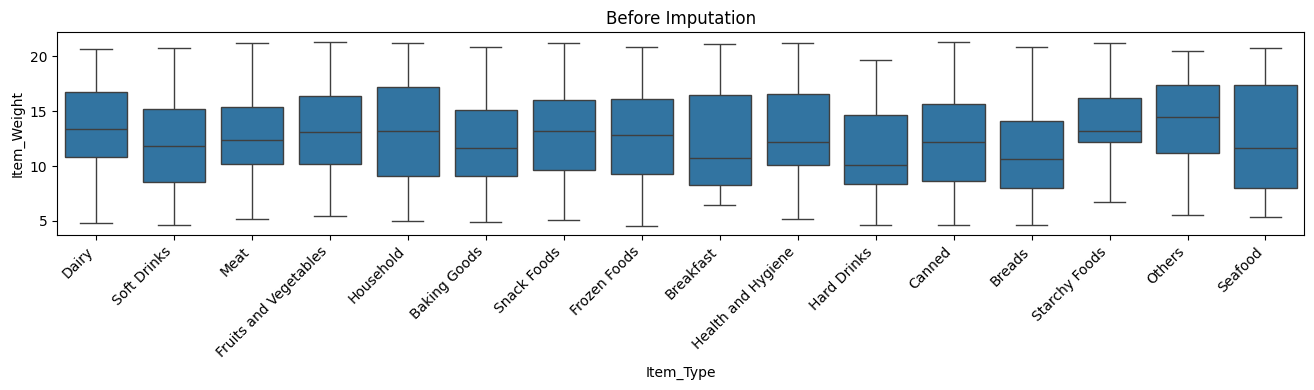

In [10]:
plt.figure(figsize=(26, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='Item_Type', y='Item_Weight', data=data[data['Item_Weight'].notnull()])
plt.title('Before Imputation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

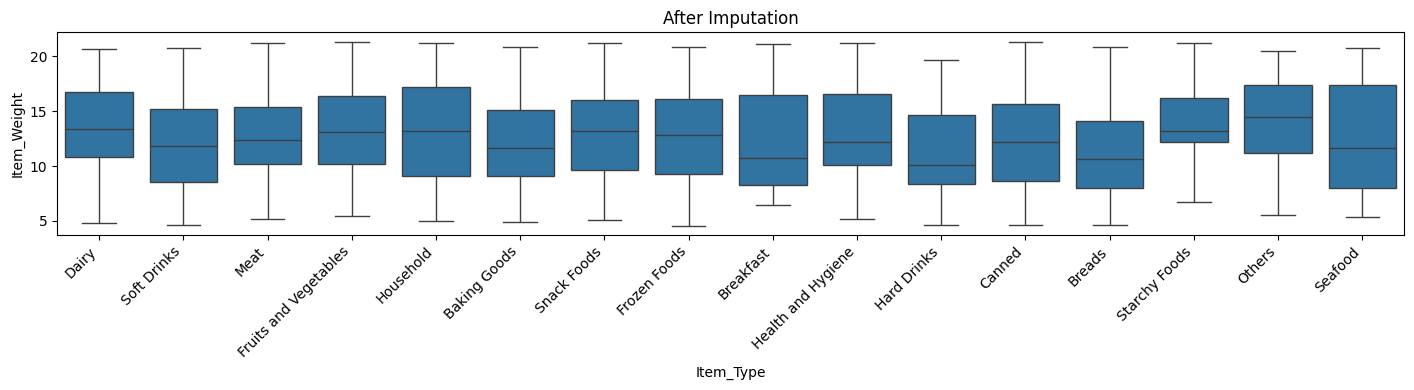

In [11]:
plt.figure(figsize=(28, 4))
plt.subplot(1, 2, 2)
sns.boxplot(x='Item_Type', y='Item_Weight', data=data)
plt.title('After Imputation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjusts layout to prevent overlap
plt.show()

#### Data Visualization
Need for Data Visualization
Data visualization is essential for several reasons:

Simplifies Complex Data: It transforms complex datasets into visual representations, making them easier to understand.
Identifies Patterns and Trends: Visuals help in spotting trends, patterns, and anomalies that might not be apparent in raw data.
Facilitates Decision Making: It aids stakeholders in making informed decisions quickly by presenting data in a clear and actionable format.
Enhances Communication: Visualizations effectively communicate findings and insights to diverse audiences, regardless of their data literacy.
Supports Data Exploration: It allows users to explore data interactively, leading to deeper insights and understanding.

In [12]:
top_performers = data.groupby('Item_Type')['Item_Outlet_Sales'].sum().reset_index()

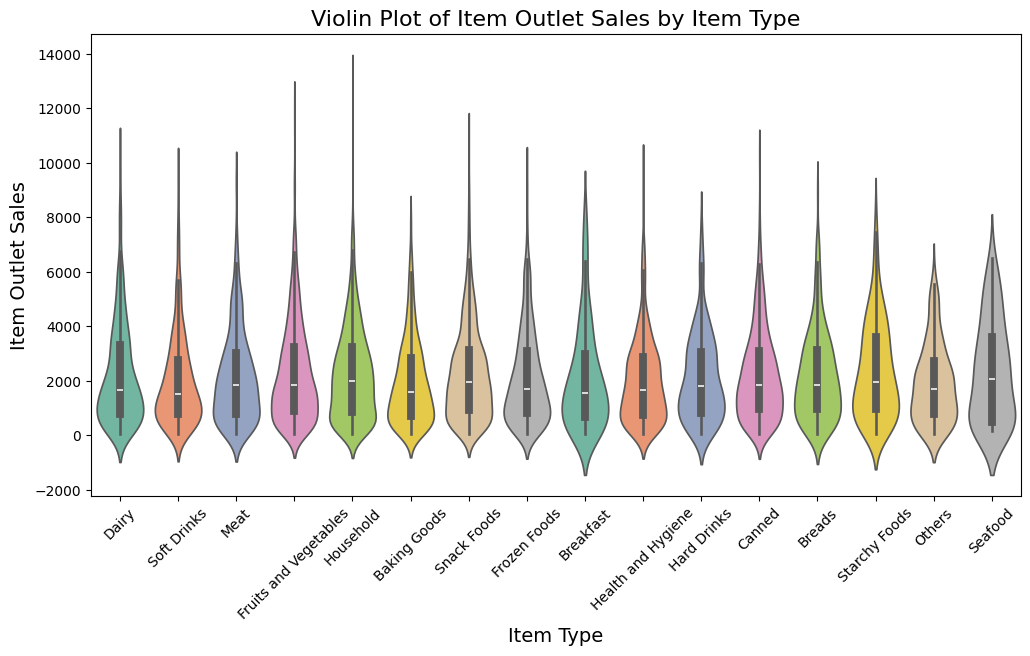

In [13]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Item_Type', y='Item_Outlet_Sales', data=data, palette='Set2')
plt.xticks(rotation=45)
plt.title('Violin Plot of Item Outlet Sales by Item Type', fontsize=16)
plt.xlabel('Item Type', fontsize=14)
plt.ylabel('Item Outlet Sales', fontsize=14)
plt.show()

#### The outlet with the highest sales in the dataset is Fruits and Vegetables.

In [14]:
top_performers = top_performers.sort_values(by='Item_Outlet_Sales', ascending=False)

In [15]:
print(top_performers)

                Item_Type  Item_Outlet_Sales
6   Fruits and Vegetables       2.820060e+06
13            Snack Foods       2.732786e+06
9               Household       2.055494e+06
5            Frozen Foods       1.825735e+06
4                   Dairy       1.522594e+06
3                  Canned       1.444151e+06
0            Baking Goods       1.265525e+06
8      Health and Hygiene       1.045200e+06
10                   Meat       9.175656e+05
14            Soft Drinks       8.928977e+05
1                  Breads       5.532372e+05
7             Hard Drinks       4.577934e+05
15          Starchy Foods       3.514013e+05
11                 Others       3.255176e+05
2               Breakfast       2.322990e+05
12                Seafood       1.488682e+05


In [16]:
top_n = top_performers.head(5)  # Change the number to however many top performers you want
print(top_n)

                Item_Type  Item_Outlet_Sales
6   Fruits and Vegetables       2.820060e+06
13            Snack Foods       2.732786e+06
9               Household       2.055494e+06
5            Frozen Foods       1.825735e+06
4                   Dairy       1.522594e+06


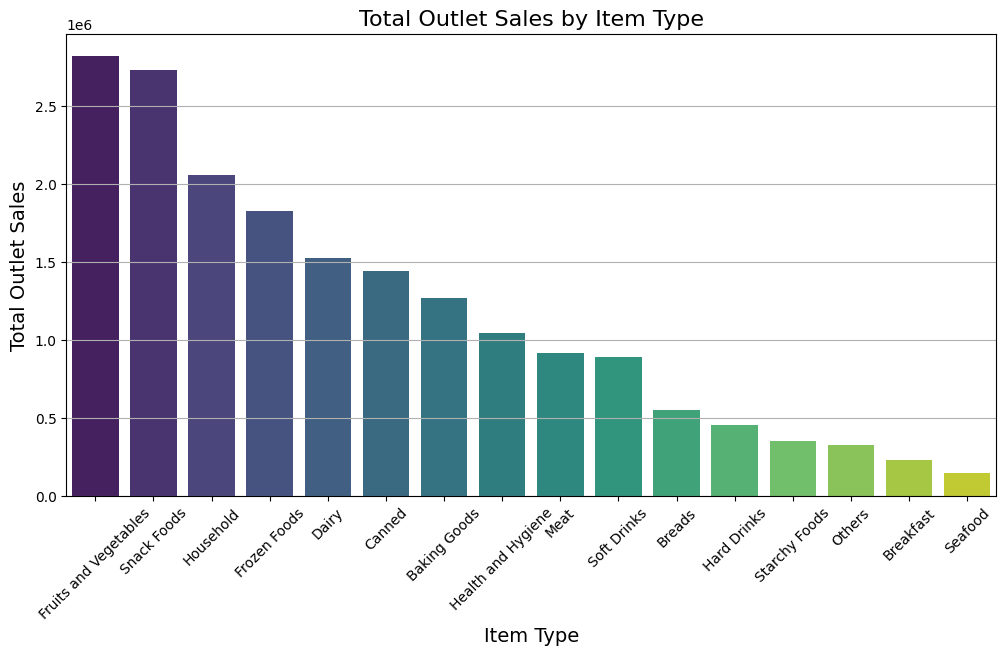

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Item_Type', y='Item_Outlet_Sales', data=top_performers, palette='viridis')
plt.title('Total Outlet Sales by Item Type', fontsize=16)
plt.xlabel('Item Type', fontsize=14)
plt.ylabel('Total Outlet Sales', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid only on the y-axis for better readability
plt.show()

In [18]:
sales_by_year = data.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].sum().reset_index()

In [19]:
sales_by_year = sales_by_year.sort_values(by='Outlet_Establishment_Year')
print(sales_by_year)

   Outlet_Establishment_Year  Item_Outlet_Sales
0                       1985       3.633620e+06
1                       1987       2.142664e+06
2                       1997       2.118395e+06
3                       1998       1.883402e+05
4                       1999       2.183970e+06
5                       2002       2.036725e+06
6                       2004       2.268123e+06
7                       2007       2.167465e+06
8                       2009       1.851823e+06


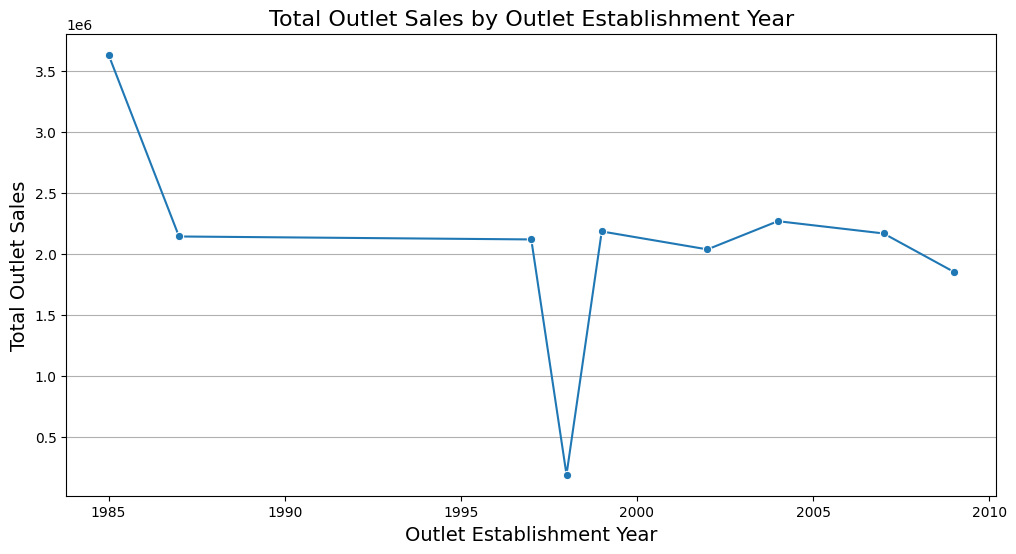

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Outlet_Establishment_Year', y='Item_Outlet_Sales', data=sales_by_year, marker='o')
plt.title('Total Outlet Sales by Outlet Establishment Year', fontsize=16)
plt.xlabel('Outlet Establishment Year', fontsize=14)
plt.ylabel('Total Outlet Sales', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add grid only on the y-axis for better readability
plt.show()

#### The year 1985 has the highest sales in the dataset.

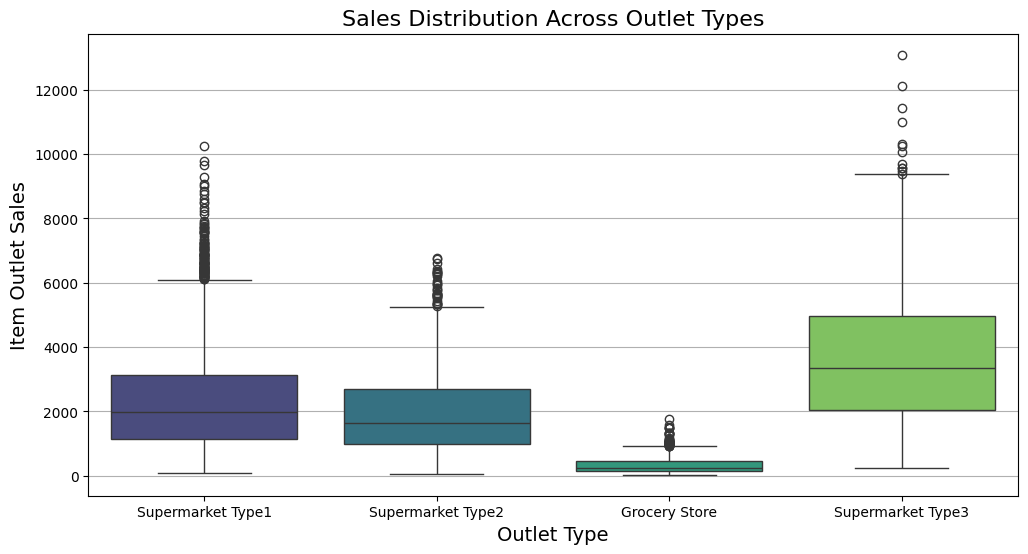

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=data, palette='viridis')
plt.title('Sales Distribution Across Outlet Types', fontsize=16)
plt.xlabel('Outlet Type', fontsize=14)
plt.ylabel('Item Outlet Sales', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y')  
plt.show()

##### Boxplot Description
A boxplot (or whisker plot) is a graphical representation that summarizes the distribution of a dataset. It displays:

Median: The line inside the box represents the median value.
Interquartile Range (IQR): The box shows the middle 50% of the data, spanning from the first quartile (Q1) to the third quartile (Q3).
Whiskers: Lines extending from the box indicate the range of the data, typically covering 1.5 times the IQR.
Outliers: Individual points outside the whiskers represent outliers in the dataset.
Boxplots are useful for comparing distributions across different groups and identifying outliers.



In [22]:
sales_summary = data.groupby('Outlet_Type')['Item_Outlet_Sales'].describe()
print(sales_summary)

                    count         mean          std       min         25%  \
Outlet_Type                                                                 
Grocery Store      1083.0   339.828500   260.851582   33.2900   153.79980   
Supermarket Type1  5577.0  2316.181148  1515.965558   73.2380  1151.16820   
Supermarket Type2   928.0  1995.498739  1375.932889   69.2432   981.55565   
Supermarket Type3   935.0  3694.038558  2127.760054  241.6854  2044.33890   

                         50%         75%         max  
Outlet_Type                                           
Grocery Store       256.9988   458.73620   1775.6886  
Supermarket Type1  1990.7420  3135.91800  10256.6490  
Supermarket Type2  1655.1788  2702.64865   6768.5228  
Supermarket Type3  3364.9532  4975.52340  13086.9648  


In [23]:
average_sales_by_size = data.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().reset_index()

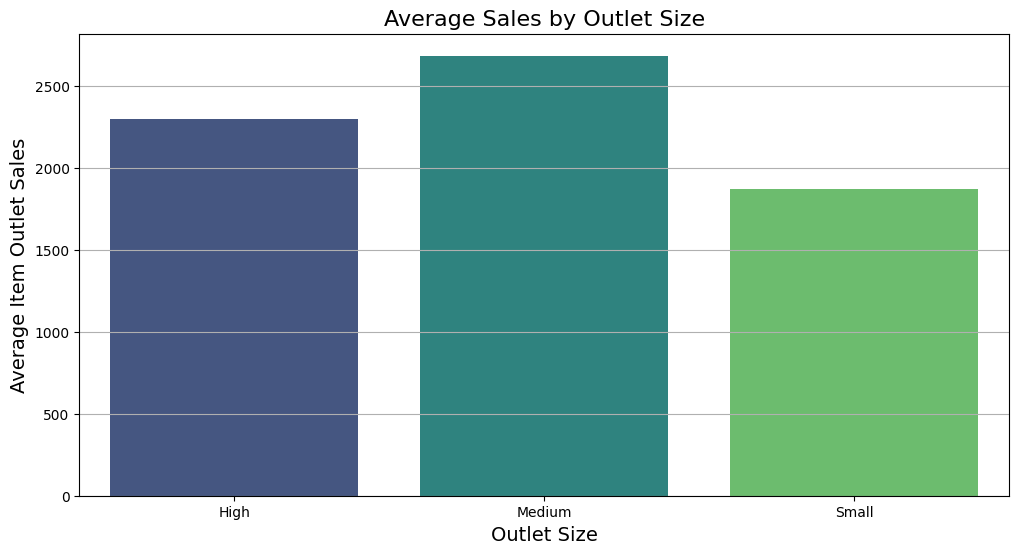

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Outlet_Size', y='Item_Outlet_Sales', data=average_sales_by_size, palette='viridis')
plt.title('Average Sales by Outlet Size', fontsize=16)
plt.xlabel('Outlet Size', fontsize=14)
plt.ylabel('Average Item Outlet Sales', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add grid only on the y-axis for better readability
plt.show()

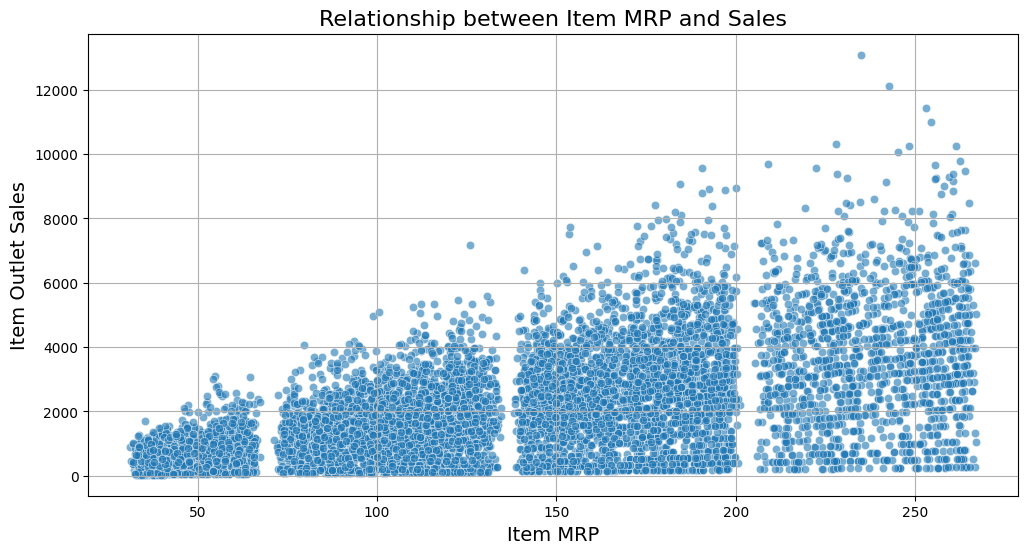

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=data, alpha=0.6, marker='o')
plt.title('Relationship between Item MRP and Sales', fontsize=16)
plt.xlabel('Item MRP', fontsize=14)
plt.ylabel('Item Outlet Sales', fontsize=14)
plt.grid()  
plt.show()

#### Scatter Plot Description
A scatter plot is a type of data visualization that uses dots to represent values for two different variables. It displays:

Individual Data Points: Each point on the plot corresponds to an observation in the dataset, with one variable plotted on the x-axis and the other on the y-axis.
Correlation: Scatter plots help visualize the relationship between the two variables, indicating whether they are positively, negatively, or not correlated.
Outliers: Points that fall far from the general distribution of data can be easily identified as outliers.
Trends: A line of best fit can be added to show the overall trend or relationship between the variables.
Scatter plots are particularly useful for identifying patterns, correlations, and distributions within the data.

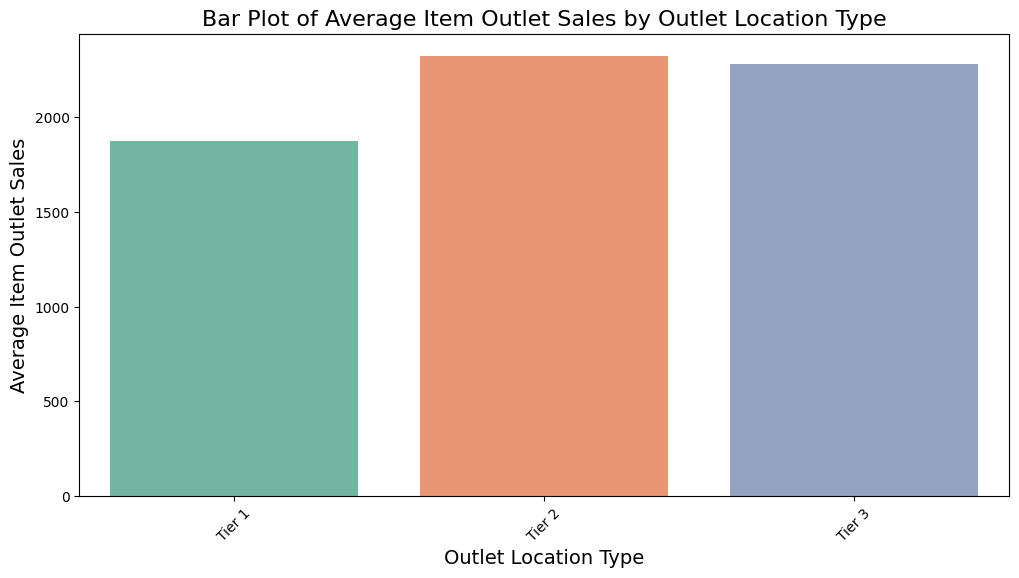

In [26]:
plt.figure(figsize=(12, 6))
mean_sales_location = data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().reset_index()
sns.barplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=mean_sales_location, palette='Set2')
plt.xticks(rotation=45)
plt.title('Bar Plot of Average Item Outlet Sales by Outlet Location Type', fontsize=16)
plt.xlabel('Outlet Location Type', fontsize=14)
plt.ylabel('Average Item Outlet Sales', fontsize=14)
plt.show()

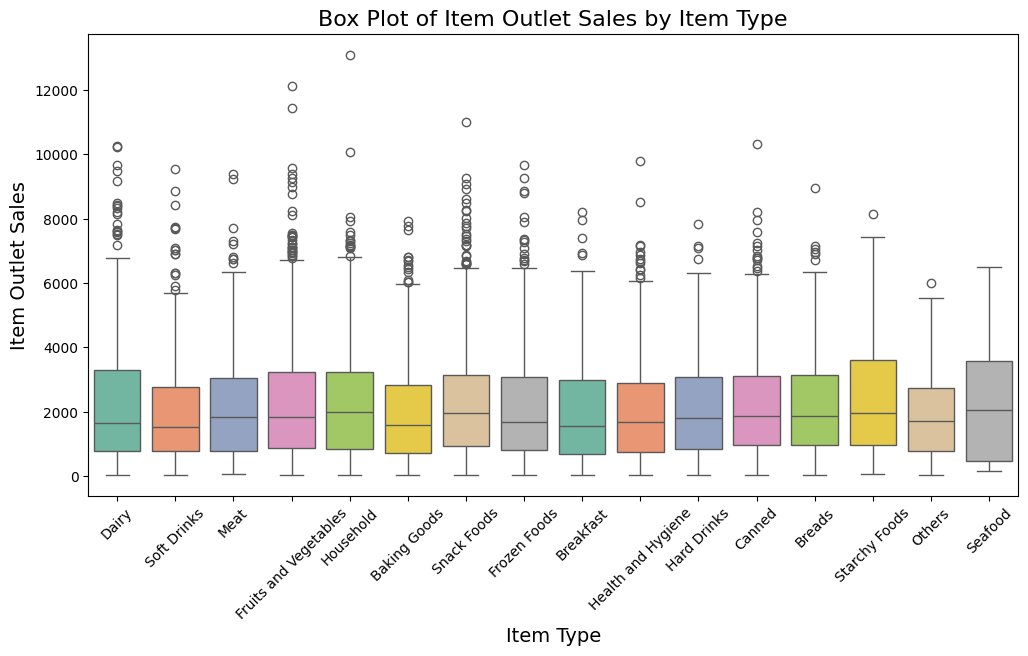

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=data, palette='Set2')
plt.xticks(rotation=45)
plt.title('Box Plot of Item Outlet Sales by Item Type', fontsize=16)
plt.xlabel('Item Type', fontsize=14)
plt.ylabel('Item Outlet Sales', fontsize=14)
plt.show()


##### checking for outliers

In [28]:
Q1 = data['Item_Weight'].quantile(0.25)
Q3 = data['Item_Weight'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['Item_Weight'] < lower_bound) | (data['Item_Weight'] > upper_bound)]
print(f"Outliers detected using IQR method:\n{outliers}")

Outliers detected using IQR method:
Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type, Item_Outlet_Sales]
Index: []


In [29]:
from scipy import stats
z_threshold = 3
data['z_score'] = stats.zscore(data['Item_Weight'])
outliers_z = data[(data['z_score'].abs() > z_threshold)]
print(f"Outliers detected using Z-score method:\n{outliers_z}")

Outliers detected using Z-score method:
Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type, Item_Outlet_Sales, z_score]
Index: []


In [30]:
Q1_vis = data['Item_Visibility'].quantile(0.25)
Q3_vis = data['Item_Visibility'].quantile(0.75)
IQR_vis = Q3_vis - Q1_vis
lower_bound_vis = Q1_vis - 1.5 * IQR_vis
upper_bound_vis = Q3_vis + 1.5 * IQR_vis
outliers_vis = data[(data['Item_Visibility'] < lower_bound_vis) | (data['Item_Visibility'] > upper_bound_vis)]
print(f"Outliers detected in Item Visibility using IQR method:\n{outliers_vis}")

Outliers detected in Item Visibility using IQR method:
     Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
49             FDS02        13.35          Regular         0.255395   
83             NCL18        13.15          Low Fat         0.293418   
108            DRE60        11.80          low fat         0.278974   
174            FDI32        17.70          Low Fat         0.291865   
334            FDC41        12.85          Low Fat         0.204700   
...              ...          ...              ...              ...   
8292           FDF56        13.10          Regular         0.209163   
8345           FDY28        12.85          Regular         0.266397   
8371           DRA59         8.27          Regular         0.214125   
8432           FDI16        14.00          Regular         0.227261   
8509           FDG45         8.10          Low Fat         0.214306   

                  Item_Type  Item_MRP Outlet_Identifier  \
49                    Dairy  196.

In [31]:
data['Item_Visibility'] = np.where(data['Item_Visibility'] > upper_bound_vis, upper_bound_vis, data['Item_Visibility'])
data['Item_Visibility'] = np.where(data['Item_Visibility'] < lower_bound_vis, lower_bound_vis, data['Item_Visibility'])
print("Outliers have been capped within the IQR bounds.")

Outliers have been capped within the IQR bounds.


In [32]:
Q1_mrp = data['Item_MRP'].quantile(0.25)
Q3_mrp = data['Item_MRP'].quantile(0.75)
IQR_mrp = Q3_mrp - Q1_mrp
lower_bound_mrp = Q1_mrp - 1.5 * IQR_mrp
upper_bound_mrp = Q3_mrp + 1.5 * IQR_mrp
outliers_mrp = data[(data['Item_MRP'] < lower_bound_mrp) | (data['Item_MRP'] > upper_bound_mrp)]
print(f"Outliers detected in Item MRP using IQR method:\n{outliers_mrp}")

Outliers detected in Item MRP using IQR method:
Empty DataFrame
Columns: [Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP, Outlet_Identifier, Outlet_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type, Item_Outlet_Sales, z_score]
Index: []


In [33]:
Q1_sales = data['Item_Outlet_Sales'].quantile(0.25)
Q3_sales = data['Item_Outlet_Sales'].quantile(0.75)
IQR_sales = Q3_sales - Q1_sales
lower_bound_sales = Q1_sales - 1.5 * IQR_sales
upper_bound_sales = Q3_sales + 1.5 * IQR_sales
outliers_sales = data[(data['Item_Outlet_Sales'] < lower_bound_sales) | (data['Item_Outlet_Sales'] > upper_bound_sales)]
print(f"Outliers detected in Item Outlet Sales using IQR method:\n{outliers_sales}")

Outliers detected in Item Outlet Sales using IQR method:
     Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
43             FDC02        21.35          Low Fat         0.069103   
130            FDY25        12.15          Low Fat         0.033810   
132            NCR53        12.15          Low Fat         0.144338   
145            FDP16        18.60          Low Fat         0.039356   
203            FDI24        11.65          Low Fat         0.078362   
...              ...          ...              ...              ...   
8245           FDU55        16.20          Low Fat         0.035967   
8329           NCQ06        13.15          Low Fat         0.041622   
8350           NCE18        10.00          Low Fat         0.021421   
8447           FDS26        20.35          Low Fat         0.089975   
8510           FDN58        13.80          Regular         0.056862   

                  Item_Type  Item_MRP Outlet_Identifier  \
43                   Canned  25

In [34]:
data['Item_Outlet_Sales'] = np.where(data['Item_Outlet_Sales'] > upper_bound_sales, upper_bound_sales, data['Item_Outlet_Sales'])
data['Item_Outlet_Sales'] = np.where(data['Item_Outlet_Sales'] < lower_bound_sales, lower_bound_sales, data['Item_Outlet_Sales'])
print("Outliers in Item_Outlet_Sales have been capped.")

Outliers in Item_Outlet_Sales have been capped.


In [35]:
print(data.columns)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'z_score'],
      dtype='object')


In [36]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    print(f"Outliers detected in {col} using IQR method:")
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(outliers[[col]])
    print("\n")

Outliers detected in Item_Weight using IQR method:
Empty DataFrame
Columns: [Item_Weight]
Index: []


Outliers detected in Item_Visibility using IQR method:
Empty DataFrame
Columns: [Item_Visibility]
Index: []


Outliers detected in Item_MRP using IQR method:
Empty DataFrame
Columns: [Item_MRP]
Index: []


Outliers detected in Outlet_Establishment_Year using IQR method:
Empty DataFrame
Columns: [Outlet_Establishment_Year]
Index: []


Outliers detected in Item_Outlet_Sales using IQR method:
Empty DataFrame
Columns: [Item_Outlet_Sales]
Index: []


Outliers detected in z_score using IQR method:
Empty DataFrame
Columns: [z_score]
Index: []




In [37]:
skewness = data[numerical_cols].skew()
print("Skewness in Numerical Columns:")
print(skewness)

Skewness in Numerical Columns:
Item_Weight                  0.118404
Item_Visibility              0.813980
Item_MRP                     0.127202
Outlet_Establishment_Year   -0.396641
Item_Outlet_Sales            0.874606
z_score                      0.118404
dtype: float64


In [38]:
data['Item_Visibility'] = np.sqrt(data['Item_Visibility'])
data['Item_Outlet_Sales'] = np.sqrt(data['Item_Outlet_Sales'])


In [39]:
print(data[['Item_Visibility', 'Item_Outlet_Sales']].skew())


Item_Visibility     -0.21558
Item_Outlet_Sales    0.12862
dtype: float64


In [40]:
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
print(data[numerical_columns].head())

   Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales
0    -0.828408        -1.008317  1.747454           1.016858
1    -1.625364        -0.892758 -1.489023          -1.207185
2     1.105037        -0.981889  0.010040           0.166297
3     1.505873        -2.211369  0.660050          -0.873790
4    -0.915649        -2.211369 -1.399220          -0.625257


In [41]:
min_max_scaler = MinMaxScaler()
data[numerical_columns] = min_max_scaler.fit_transform(data[numerical_columns])
print(data[numerical_columns].head())

   Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales
0     0.282525         0.286152  0.927507           0.739283
1     0.081274         0.313638  0.072068           0.204207
2     0.770765         0.292438  0.468288           0.534649
3     0.871986         0.000000  0.640093           0.284418
4     0.260494         0.000000  0.095805           0.344212


In [42]:
print(data[numerical_columns].min())
print(data[numerical_columns].max())


Item_Weight          0.0
Item_Visibility      0.0
Item_MRP             0.0
Item_Outlet_Sales    0.0
dtype: float64
Item_Weight          1.0
Item_Visibility      1.0
Item_MRP             1.0
Item_Outlet_Sales    1.0
dtype: float64


In [43]:
print(data.dtypes)

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
z_score                      float64
dtype: object


In [44]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

In [45]:
print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)

Numerical Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'z_score'],
      dtype='object')
Categorical Columns: Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


In [46]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 
                       'Outlet_Identifier', 'Outlet_Size', 
                       'Outlet_Location_Type', 'Outlet_Type']
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])
print(data.head())

   Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type  \
0              156     0.282525                 1         0.286152          4   
1                8     0.081274                 2         0.313638         14   
2              662     0.770765                 1         0.292438         10   
3             1121     0.871986                 2         0.000000          6   
4             1297     0.260494                 1         0.000000          9   

   Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  \
0  0.927507                  9                       1999            1   
1  0.072068                  3                       2009            1   
2  0.468288                  9                       1999            1   
3  0.640093                  0                       1998            2   
4  0.095805                  1                       1987            0   

   Outlet_Location_Type  Outlet_Type  Item_Outlet_Sales   z_score  


In [47]:
print(data.dtypes)

Item_Identifier                int32
Item_Weight                  float64
Item_Fat_Content               int32
Item_Visibility              float64
Item_Type                      int32
Item_MRP                     float64
Outlet_Identifier              int32
Outlet_Establishment_Year      int64
Outlet_Size                    int32
Outlet_Location_Type           int32
Outlet_Type                    int32
Item_Outlet_Sales            float64
z_score                      float64
dtype: object


In [48]:
X = data.drop(columns=['Item_Outlet_Sales'])  
y = data['Item_Outlet_Sales'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (6818, 12)
Testing data shape: (1705, 12)


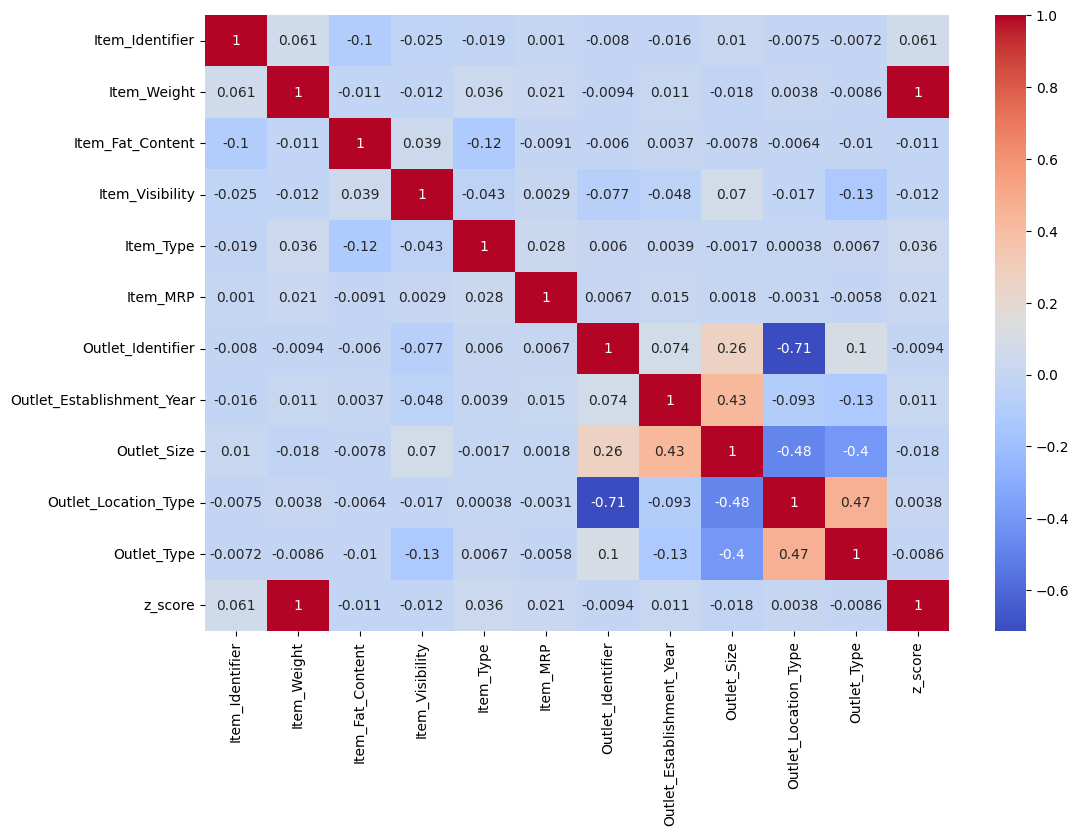

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap of correlations to see if any feature has high correlation with the target
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [50]:
!pip install statsmodels


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif
corr_matrix = X_train.corr()
print(corr_matrix)
vif_before = calculate_vif(X_train)
print("VIF before dropping features:")
print(vif_before)
X_train_reduced = X_train.drop(['Outlet_Location_Type'], axis=1)
X_test_reduced = X_test.drop(['Outlet_Location_Type'], axis=1)
vif_after = calculate_vif(X_train_reduced)
print("VIF after dropping features:")
print(vif_after)

                           Item_Identifier  Item_Weight  Item_Fat_Content  \
Item_Identifier                   1.000000     0.061045         -0.101889   
Item_Weight                       0.061045     1.000000         -0.011162   
Item_Fat_Content                 -0.101889    -0.011162          1.000000   
Item_Visibility                  -0.024934    -0.012426          0.038821   
Item_Type                        -0.018741     0.035623         -0.117313   
Item_MRP                          0.001022     0.020824         -0.009121   
Outlet_Identifier                -0.008006    -0.009370         -0.005957   
Outlet_Establishment_Year        -0.016356     0.010929          0.003699   
Outlet_Size                       0.010241    -0.018041         -0.007831   
Outlet_Location_Type             -0.007506     0.003822         -0.006407   
Outlet_Type                      -0.007185    -0.008621         -0.010319   
z_score                           0.061045     1.000000         -0.011162   

#### Drop Item_Weight and Recalculate VIF

In [52]:
X_train_reduced = X_train_reduced.drop(['Item_Weight'], axis=1)
X_test_reduced = X_test_reduced.drop(['Item_Weight'], axis=1)
vif_after_drop = calculate_vif(X_train_reduced)
print("VIF after dropping 'Item_Weight':")
print(vif_after_drop)

VIF after dropping 'Item_Weight':
                     Feature        VIF
0            Item_Identifier   4.081608
1           Item_Fat_Content   5.627122
2            Item_Visibility   6.034315
3                  Item_Type   4.066252
4                   Item_MRP   4.134196
5          Outlet_Identifier   4.298765
6  Outlet_Establishment_Year  34.589478
7                Outlet_Size   7.524941
8                Outlet_Type   4.187003
9                    z_score   1.006284


In [53]:
X_train_final = X_train_reduced.drop(['Outlet_Size'], axis=1)
X_test_final = X_test_reduced.drop(['Outlet_Size'], axis=1)
vif_final = calculate_vif(X_train_final)
print("VIF after dropping 'Outlet_Size':")
print(vif_final)

VIF after dropping 'Outlet_Size':
                     Feature        VIF
0            Item_Identifier   4.081280
1           Item_Fat_Content   5.625522
2            Item_Visibility   6.024390
3                  Item_Type   4.066221
4                   Item_MRP   4.134041
5          Outlet_Identifier   3.820940
6  Outlet_Establishment_Year  27.846741
7                Outlet_Type   3.358990
8                    z_score   1.005793


In [54]:
X = data.drop(columns=['Item_Outlet_Sales'])  
y = data['Item_Outlet_Sales'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train_imputed = imputer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_imputed)

In [56]:
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

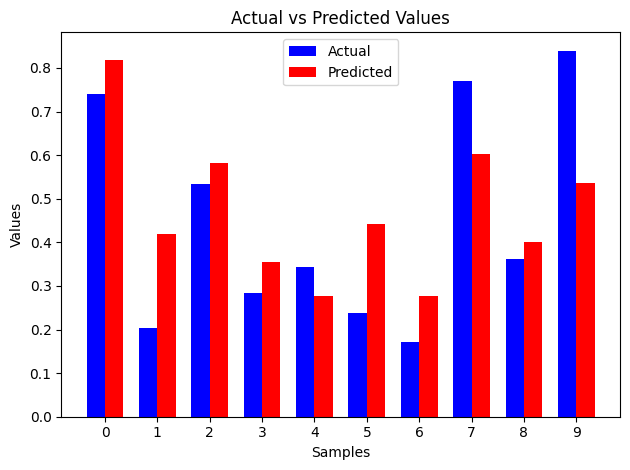

In [64]:
actual_values = y_test[:10]  
predicted_values = test_preds[:10]
index = np.arange(len(actual_values))
bar_width = 0.35
plt.bar(index, actual_values, bar_width, label='Actual', color='b')
plt.bar(index + bar_width, predicted_values, bar_width, label='Predicted', color='r')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.xticks(index + bar_width / 2, index)
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
X_train = data.drop('Item_Outlet_Sales', axis=1)
y_train = data['Item_Outlet_Sales']
X_test = data.drop('Item_Outlet_Sales', axis=1)
y_test = data['Item_Outlet_Sales']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

r2_scores = {'Model': [], 'Training R²': [], 'Testing R²': []}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    train_preds = model.predict(X_train_scaled)
    test_preds = model.predict(X_test_scaled)
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    r2_scores['Model'].append(model_name)
    r2_scores['Training R²'].append(train_r2)
    r2_scores['Testing R²'].append(test_r2)
r2_scores_data = pd.DataFrame(r2_scores)
print(r2_scores_data)

               Model  Training R²  Testing R²
0  Linear Regression     0.559665    0.559665
1      Random Forest     0.950121    0.950121
2                SVR     0.716406    0.716406
3                KNN     0.731683    0.731683
4            XGBoost     0.867280    0.867280
5              Lasso     0.000000    0.000000
6              Ridge     0.559665    0.559665


### Random forest comes as best model for this

In [65]:
X_train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,z_score
0,156,0.282525,1,0.286152,4,0.927507,9,1999,1,0,1,-0.828408
1,8,0.081274,2,0.313638,14,0.072068,3,2009,1,2,2,-1.625364
2,662,0.770765,1,0.292438,10,0.468288,9,1999,1,0,1,1.105037
3,1121,0.871986,2,0.000000,6,0.640093,0,1998,2,2,0,1.505873
4,1297,0.260494,1,0.000000,9,0.095805,1,1987,0,2,1,-0.915649
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,370,0.137541,1,0.538277,13,0.777729,1,1987,0,2,1,-1.402547
8519,897,0.227746,2,0.489624,0,0.326263,7,2002,2,1,1,-1.045331
8520,1357,0.359929,1,0.423723,8,0.228492,6,2004,2,1,1,-0.521886
8521,681,0.158083,2,0.860814,13,0.304939,3,2009,1,2,2,-1.321200


In [66]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                      Feature  Importance
5                    Item_MRP    0.417847
10                Outlet_Type    0.317360
3             Item_Visibility    0.070272
0             Item_Identifier    0.048741
7   Outlet_Establishment_Year    0.040416
4                   Item_Type    0.023513
1                 Item_Weight    0.023393
11                    z_score    0.023308
6           Outlet_Identifier    0.014391
2            Item_Fat_Content    0.010551
9        Outlet_Location_Type    0.005309
8                 Outlet_Size    0.004898


In [67]:
features_to_drop = ['Outlet_Size', 'Outlet_Location_Type', 'Item_Fat_Content']
X_train_reduced = X_train.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

In [68]:
rf_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)
train_preds_reduced = rf_reduced.predict(X_train_reduced)
test_preds_reduced = rf_reduced.predict(X_test_reduced)
train_r2_reduced = r2_score(y_train, train_preds_reduced)
test_r2_reduced = r2_score(y_test, test_preds_reduced)
print(f"Training R² with reduced features: {train_r2_reduced}")
print(f"Testing R² with reduced features: {test_r2_reduced}")

Training R² with reduced features: 0.9496896875011378
Testing R² with reduced features: 0.9496896875011378


##### Rnadom forest fits best